Converted to pandas but did not get totally runnning correctly yet. There are problems with calculating Voc, but looks like other parts are working correctly

In [2]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
 
import blackbody as bb
import detailedbalance as db
import plots as plots

#font = {'size' : 14}

matplotlib.rc('font',**{'size' : 16})
%matplotlib inline

In [3]:
# Just some constants for the upcoming math
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant in eV s')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant in eV/K')

pi = 3.1415

# Globals
Tcell = 300  # Kelvin
# Energy Gap
Egap = 1.1  #electron volts

r_earth = 6e6
r_sun = 6.95e8
d_sun = 1.50e11

In [4]:
E_ph = np.arange(0.01, 10,0.001) 
E_ph = np.flip(E_ph,0)

E_gaps = np.arange(0.3, 5,0.01) 
E_gaps = np.flip(E_gaps,0)

sourcetype = 1

constants = {}

# sourcetype 1 for sun and 0 for full angle. This should perhaps be combined with the max_eff_temp function
if(sourcetype):
    #Sun
    constants['Temp'] = 5750
    constants['solidangle'] = bb.solid_angle_sun(r_earth,d_sun)
    constants['emitterarea'] = 4*pi*r_sun**2
    constants['absorberarea'] = pi*r_earth**2
else:
    #Custom
    constants['Temp'] = 1800
    constants['solidangle'] = 2*pi
    constants['emitterarea'] = 1
    constants['absorberarea'] = 1
    
emissivity = bb.stepfn(1,1,1.1,E_ph)

#constants['emissivity'] = bb.stepfn(10**-10,10**-30,1.1,E_ph)

#constants['emissivity'] = bb.lorentzian(0.1,1,1.5,0.1,E_ph)
   
BB = bb.gen_spectrum(E_ph,constants)


#check integrated irradiance is ~1kW/m^2
integrate = np.trapz(BB, BB.index)
print(integrate)

#BB[:,1] = BB[:,1]/integrate
#BB[:,1] = BB[:,1]
#BB[:,1] = 0

BB_ph = bb.power_to_photons(BB)

print(bb.stephan(5750)*4*pi*r_sun**2)

-1330.624524633602
3.762263521545546e+26


In [5]:
BB[2:1]

2.000    488.931740
1.999    489.202745
1.998    489.473568
1.997    489.744211
1.996    490.014671
1.995    490.284948
1.994    490.555042
1.993    490.824951
1.992    491.094674
1.991    491.364212
1.990    491.633563
1.989    491.902726
1.988    492.171701
1.987    492.440487
1.986    492.709083
1.985    492.977489
1.984    493.245703
1.983    493.513725
1.982    493.781554
1.981    494.049189
1.980    494.316630
1.979    494.583876
1.978    494.850925
1.977    495.117778
1.976    495.384433
1.975    495.650890
1.974    495.917147
1.973    496.183205
1.972    496.449062
1.971    496.714718
            ...    
1.030    531.075767
1.029    530.753513
1.028    530.430307
1.027    530.106147
1.026    529.781034
1.025    529.454967
1.024    529.127947
1.023    528.799973
1.022    528.471047
1.021    528.141166
1.020    527.810332
1.019    527.478545
1.018    527.145805
1.017    526.812111
1.016    526.477463
1.015    526.141863
1.014    525.805309
1.013    525.467802
1.012    525.129341


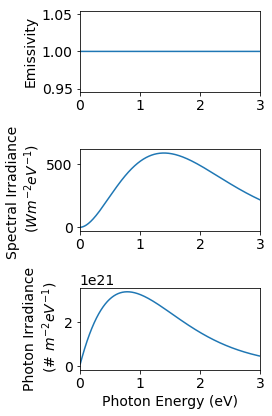

In [6]:
plots.em_ir_ph_plot(BB, BB_ph, emissivity )

In [7]:
db.photons_above_bandgap(1.1,BB_ph)

3.3080832379594426e+21

Si Efficiency at 1500C 3.1782448086244156e-06
Si Power at 1500C 3.8242700700866484e-07


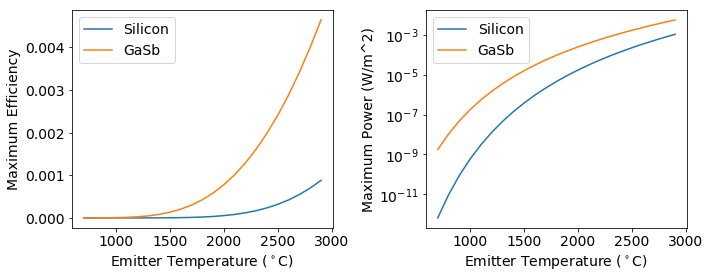

In [8]:
temps = pd.Series(np.arange(700,3000,100))

spectra_ph_temp = pd.Series(index = temps,dtype=object)
for temp in temps:
    constants['Temp'] = temp +273.15
    spectra = bb.gen_spectrum(E_ph,constants)
    spectra_ph_temp[temp] = bb.power_to_photons(spectra)
    
max_eff_all_Si_temp, max_eff_all_GaSb_temp, max_pow_all_Si_temp,max_pow_all_GaSb_temp = db.max_eff_array(spectra_ph_temp,temps)

matplotlib.rc('font',**{'size' : 14})

w,h =plt.figaspect(0.4) 
fig, ax = plt.subplots(1,2,figsize = (w,h) )


ln1 = ax[0].plot(max_eff_all_Si_temp)
ln2 = ax[0].plot(max_eff_all_GaSb_temp)
ax[0].set_ylabel('Maximum Efficiency')
ax[0].set_xlabel('Emitter Temperature ($^\circ$C)')
lns = ln1 + ln2
ax[0].legend(lns, ('Silicon','GaSb'))

ln1 = ax[1].semilogy(max_pow_all_Si_temp)
ln2 = ax[1].semilogy(max_pow_all_GaSb_temp)
lns = ln1 + ln2
ax[1].legend(lns, ('Silicon','GaSb'))
ax[1].set_ylabel('Maximum Power (W/m^2)')
ax[1].set_xlabel('Emitter Temperature ($^\circ$C)')

matplotlib.rc('font',**{'size' : 11})


if(False):
    left, bottom, width, height = [0.32, 0.31, 0.125, 0.25]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.plot(E_ph,constants['emissivity'], color = 'black')
    ax2.set_xlabel('Photon Energy (eV)')
    ax2.set_ylabel('Emissivity')
    ax2.set_xlim((0,3))
    ax2.set_ylim((0,1.1))


plt.tight_layout()
print("Si Efficiency at 1500C", max_eff_all_Si_temp[1500])
print("Si Power at 1500C", max_pow_all_Si_temp[1500])

In [9]:
print('For a cell with bandgap %.2f eV' % Egap)
print('max power %.2f' % db.max_power(Egap, BB_ph) )
print('Irradiance %.2f' % db.int_irr(Egap, BB_ph ))
print('Ideal efficiency is {:.4}%'.format(db.max_eff(Egap, BB_ph)*100))

For a cell with bandgap 1.10 eV
max power 0.28
Irradiance 1330.62
Ideal efficiency is 0.0209%


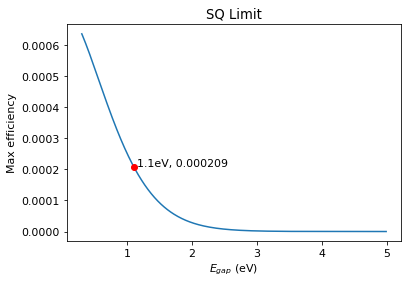

In [10]:
plots.sq_limit_plot(BB_ph,E_gaps)

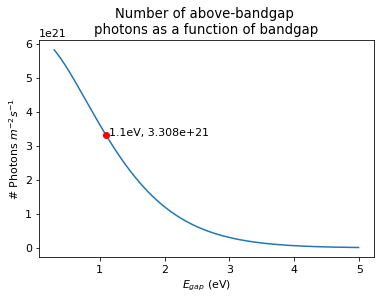

In [11]:
plots.photons_above_bandgap_plot(BB_ph,E_gaps)

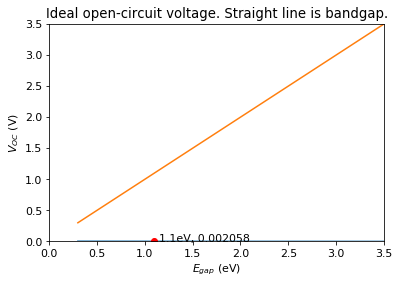

In [12]:
plots.ideal_voc_plot(BB_ph,E_gaps)

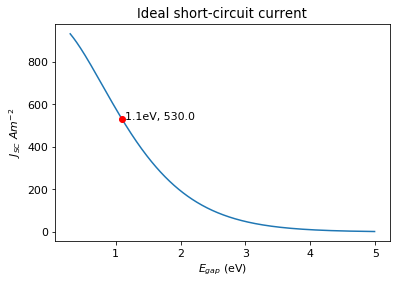

In [43]:
plots.ideal_jsc_plot(BB_ph,E_gaps)

In [12]:
# For an ideal solar cell these will be
print('A material with a bandgap of %.2f will have an:' % Egap)
print('Ideal short circuit current: ', db.jsc(Egap, BB_ph), 'A/m^2')
print('Ideal open circuit  voltage: ', db.voc(Egap, BB_ph), 'V')


#watch out for minus 1

A material with a bandgap of 1.10 will have an:
Ideal short circuit current:  16268.044929491316 A/m^2
Ideal open circuit  voltage:  0.03270108048979523 V


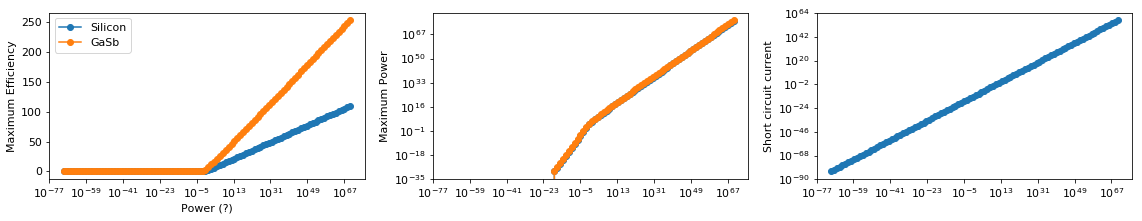

In [14]:
#This plot shows two problems at very high and very low powers. 
#My interpretation so far:
#At high powers the quasi-Fermi level splitting is becoming much larger than the bandgap and the approximatinon of an exponentially increasing radiative recombination rate is no loger valid. The open-circuit voltage will grow much slower than this.
#At low powers something in the code is causing a constant 'genration' rate which is giving charge carriers for no PAG and a blowing up efficiency.

powers = pd.Series(np.logspace(-70, 70,100))
spectra_ph_pow = pd.Series(index = powers,dtype=object)
irr_pow = pd.Series(index = powers,dtype=object)
jscs = pd.Series(index = powers,dtype=object)
for power in powers:
    spectra = bb.gen_spectrum(E_ph,constants)
    spectra = spectra*power
    spectra_ph_pow[power] = bb.power_to_photons(spectra)
    #irr_pow[power] = db.int_irr(1.1,spectra)
    jscs[power] =  db.jsc(1.1,spectra)
    
    
max_eff_all_Si_pow, max_eff_all_GaSb_pow, max_pow_all_Si_pow,max_pow_all_GaSb_pow = db.max_eff_array(spectra_ph_pow,powers)

w,h =plt.figaspect(.2) 
fig, ax = plt.subplots(1,3,figsize = (w,h) )

ln1 = ax[0].semilogx(max_eff_all_Si_pow, '-o')
ln2 = ax[0].semilogx(max_eff_all_GaSb_pow,'-o')
ax[0].set_ylabel('Maximum Efficiency')
ax[0].set_xlabel('Power (?)')
lns = ln1 + ln2
ax[0].legend(lns, ('Silicon','GaSb'))

ln1 = ax[1].plot(max_pow_all_Si_pow, '-o')
ln2 = ax[1].loglog(max_pow_all_GaSb_pow,'-o')
ax[1].set_ylabel('Maximum Power')

#ln1 = ax[2].loglog(irr_pow, '-o')
ln1 = ax[2].loglog(jscs, '-o')
ax[2].set_ylabel('Short circuit current')
plt.tight_layout()

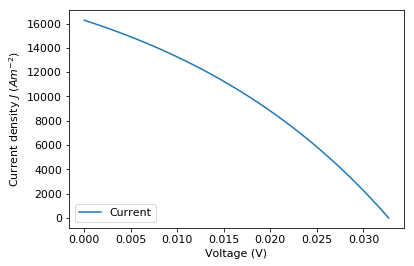

In [15]:
plots.iv_curve_plot(1.1, BB_ph)